# Task 1 - Patient Scenarios

In this code, we load 11 patient stems and 4 Hgb levels, creating 44 scenarios. We define a way to systematically query the GPT API with these scenarios, and then for each `model` in `models` we test all scenarios. We do this in batches of `batch_size` and we repeat our tests for a number of `duplication_folds`. The code beyond that is a little more hacked together, but we generate some tables to see how our models perform relative to the truth table (see paper).

This code should run with relatively little setup. Be sure to have initialized an OpenAI account (see https://platform.openai.com/docs/api-reference/introduction). Once you have done that, point `openai.api_key_path` to wherever you have saved your API key.

In [1]:
import openai
import time
import pandas as pd
import numpy as np
import requests.exceptions
import random

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

print(f'{pd.__version__=}, {np.__version__=}, {matplotlib.__version__=}')

from io import StringIO

pd.__version__='1.5.3', np.__version__='1.23.5', matplotlib.__version__='3.7.0'


In [22]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Edit the code below to wherever your API key lives.

In [2]:
openai.api_key_path = 'api_key'

Models:

- gpt-4-0314 : Snapshot of gpt-4 from March 14th 2023. 8k model. \$0.0300 per 1k tokens (15x cost of 3.5). Max 8,192 tokens per request.
- gpt-3.5-turbo : most powerful (current) model, costs \$0.0020 per 1k tokens. Max 4,096 tokens per request. Current version is gpt-3.5-turbo-0301. Trained up to Sept 2021.
- ada : fastest model, costs \$0.0004 per 1k tokens (1/5 of 3.5). Max 2,049 tokens per request. Trained up to Oct 2019.
- babbage : slightly slower than ada, but more nuanced. Costs \$0.0005 per 1k tokens. Max 2,049 tokens per request. Trained up to Oct 2019.
- curie : again slower, costs \$0.0020 per 1k tokens (same price as 3.5). Max 2,049 tokens per request. Trained up to Oct 2019.
- davinci : strongest 3.0 model, comparable to 3.5 turbo. Costs \$0.0200 per 1k tokens (10x cost of 3.5). Max 2,049 tokens per request. Trained up to Oct 2019.

In [3]:
with open('patient_stems.txt') as f:
    pt_stems = [line.strip() for line in f]
    
hgb_levels = [
    '5.5 g/dL.',
    '7.2 g/dL.',
    '8.5 g/dL.',
    '10.8 g/dL.',
]
    
print(f'Scenarios loaded. There are currently {len(pt_stems)*len(hgb_levels)} possible scenarios.')

scenarios = []
for i in range(len(pt_stems)):
    for j in range(len(hgb_levels)):
        patient = f'{i+1}' + chr(ord('A') + j)
        scenario = f'Patient {patient}: {pt_stems[i]} {hgb_levels[j]}'
        scenarios.append(scenario)

scenarios[:2]

Scenarios loaded. There are currently 44 possible scenarios.


['Patient 1A: A 71-year-old, 81 kg man with a history of atrial fibrillation had surgical repair of a traumatic hip fracture yesterday. He is currently in the orthopedic ward. His hemoglobin is 5.5 g/dL.',
 'Patient 1B: A 71-year-old, 81 kg man with a history of atrial fibrillation had surgical repair of a traumatic hip fracture yesterday. He is currently in the orthopedic ward. His hemoglobin is 7.2 g/dL.']

## Test Parameters

Change the two cells below in order to determine which models are used and which testing parameters are used.

In [4]:
models = ['gpt-3.5-turbo-0301', 'gpt-4-0314']

In [5]:
batch_size = 5
duplication_folds = 50

## Useful Functions

First function creates a `messages` list that will feed into the GPT API.

Second function cleans some logic to handle errors when the API is busy or throwing errors. Also tries to make sure that the GPT returned data in a table, as requested.

Third function gives some simple stats.

In [ ]:
def get_messages(prompts):
    messages = [
        {'role': 'system', 'content': 'You are an assistant to an anesthesiologist planning procedures.'},
        {'role': 'user', 'content': 'You are an assistant for a hospital transfusion medicine physician reviewing requests for red blood cell transfusion. For each case, please indicate whether a red blood cell transfusion is indicated (1 for “yes” or 0 “no”). Please also indicate what the minimum post-transfusion hemoglobin goal is, in units of g/dL. Unless stated otherwise, assume that every patient is hemodynamically stable and not actively bleeding. Please format your table as a csv that uses ; as the separator. Denote the start and end of your table with three tildes (~~~). Use `ID`, `transfusion`, and `target` as the columns in the table and do not include the word "Patient" when giving the ID of the patient. In the `target` column give your answer as a number with one decimal place and no units (the unlabeled units are g/dL). If there is no applicable target, the entry should be empty. Here is an example response: `~~~\nID;transfusion;target\nXX;1;7.0\nYY;0;\nZZ;1;9.5\n~~~`'},
        {'role': 'assistant', "content": "Sure, I can help you with that. Please provide me with the patient scenarios.",},
        #{
        #    'role': 'user',
        #    'content': PROMPT_HERE
        #},
    ]
    for p in prompts:
        messages.append(
                {
            'role': 'user',
            'content': p
        }
            )

    return messages

In [7]:
def val_response(response):
    if response['choices'][0]['finish_reason'] != 'stop':
        raise Exception('Response failed- message incomplete')
            
    if len(response['choices'][0]['message']['content'].split('~~~')) < 2:
        print('\nError occurred with response. Likely misformatted:')
        print(response['choices'][0]['message']['content'])
        raise Exception('Response failed- message misformatted')
        
    return True

In [20]:
def get_metrics(y_true, y_pred):
    # Assume y_true and y_pred are the true and predicted binary labels
    # for a set of test examples
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Extract true positive, false negative, false positive, and true negative counts
    tn, fp, fn, tp = cm.ravel()
    
    # Print metrics
    print(f'True positives: {tp}, False negatives: {fn}, False positives: {fp}, True negatives: {tn}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')


## Testing Loop

In [8]:
results = {m : [] for m in models}
for model in models:
    print(f'Starting with {model=}, {batch_size=}, {duplication_folds=}')
    # Shuffle the scenarios
    random.seed(1234)
    random.shuffle(scenarios)
    
    token_count = 0
    start_time = time.time()
    for fold in range(duplication_folds):
        
        #print(f"Starting fold {fold}", end=" ")
        random.shuffle(scenarios)
        
        for i in range(0, len(scenarios), batch_size):
            thous_tokens = token_count // 1000
            if 'gpt-4' in model:
                cost = 0.03 * thous_tokens
            elif 'gpt-3.5' in model:
                cost = 0.002 * thous_tokens
            else:
                cost = float('inf')
            #print(f'{i=}, {thous_tokens=:.0f}k tokens ${cost:.3f}', end=' ')
            
            while True:
                try:
                    response = openai.ChatCompletion.create(
                        model=model,
                        messages=get_messages(scenarios[i:i+batch_size]),
                        temperature=0,
                    )
                    if val_response(response):
                        break
                except (
                    openai.error.APIConnectionError,
                    requests.exceptions.Timeout,
                    requests.exceptions.ConnectionError,
                    openai.error.APIError,
                    openai.error.ServiceUnavailableError,
                    TimeoutError
                ) as e:
                    print(f"\nConnection error occurred: {str(e)[:50]}: Retrying in 30 seconds...")
                    time.sleep(30)                
                except Exception as e:
                    print(f"\nUnexpected error occurred: {str(e)[:50]}. Retrying in 30 seconds...")
                    time.sleep(30)
                    
            token_count += response['usage']['total_tokens']
            r = response['choices'][0]['message']['content'].split('~~~')[1].strip()
            results[model].append(pd.read_csv(StringIO(r), sep=';'))
            #print(f"completed. Tokens: {response['usage']['total_tokens']}, time elapsed: {time.time()-start_time:.2f}s")
        #print(f'Finished fold {fold}. Total time elapsed: {time.time()-start_time:.2f}s')
        print('*',end='')
    print(f'\nTask completed on {model=} with {token_count} total tokens and a total cost of ${cost:.2f}. Total time elapsed: {time.time()-start_time:.2f}s ({(time.time()-start_time)/60:.2f} minutes)')


Starting with model='gpt-3.5-turbo-0301', batch_size=5, duplication_folds=50
**************************************************
Task completed on model='gpt-3.5-turbo-0301' with 295876 total tokens and a total cost of $0.59. Total time elapsed: 1760.89s (29.35 minutes)
Starting with model='gpt-4-0314', batch_size=5, duplication_folds=50
*******
Unexpected error occurred: That model is currently overloaded with other requ. Retrying in 30 seconds...
********
Unexpected error occurred: That model is currently overloaded with other requ. Retrying in 30 seconds...
***
Unexpected error occurred: That model is currently overloaded with other requ. Retrying in 30 seconds...
****
Unexpected error occurred: That model is currently overloaded with other requ. Retrying in 30 seconds...
***********************
Unexpected error occurred: That model is currently overloaded with other requ. Retrying in 30 seconds...
*****
Task completed on model='gpt-4-0314' with 275184 total tokens and a total cost o

## Data Reformatting

Collates data into a unified `df` per model. Note that this is hardcoded, so should rewrite if you use new/different models. Saves models to results and loads in the truth table.

In [12]:
pd.concat(results['gpt-3.5-turbo-0301'], ignore_index=True).to_csv('results/txf_3-5-apr_30_23.csv')
pd.concat(results['gpt-4-0314'], ignore_index=True).to_csv('results/txf4-apr_30_23.csv')

In [13]:
full_results_3_5 = pd.concat(results['gpt-3.5-turbo-0301'], ignore_index=True)
full_results_4   = pd.concat(results['gpt-4-0314'], ignore_index=True)

In [18]:
df_3_5 = full_results_3_5.groupby(['ID']).agg({'transfusion': 'mean'})
df_3_5.reset_index(inplace=True)
df_3_5.rename(columns={'transfusion': 'GPT3_5'}, inplace=True)

df_4 = full_results_4.groupby(['ID']).agg({'transfusion': 'mean'})
df_4.reset_index(inplace=True)
df_4.rename(columns={'transfusion': 'GPT_4'}, inplace=True)

key = pd.read_csv('results/key.csv')

In [19]:
df = key.merge(df_3_5, on='ID', how='outer')
df = df.merge(df_4, on='ID', how='outer')
df.head()

,ID,transfusion,GPT3_5,GPT_4
0,1A,1,1.00,1.00
1,1B,1,0.82,0.76
2,1C,0,0.40,0.16
3,1D,0,0.00,0.00
4,2A,1,1.00,1.00


In [28]:
df.to_csv('results/txf_4_30_compiled.csv')

## Data Visualization

Summary statistics for GPT 3.5 assuming a probability cutoff of >0.5:
True positives: 16, False negatives: 0, False positives: 16, True negatives: 12
Accuracy: 0.6364
Precision: 0.5000
Recall: 1.0000
F1 score: 0.6667
Summary statistics for GPT 4 assuming a probability cutoff of >0.5:
True positives: 16, False negatives: 0, False positives: 8, True negatives: 20
Accuracy: 0.8182
Precision: 0.6667
Recall: 1.0000
F1 score: 0.8000


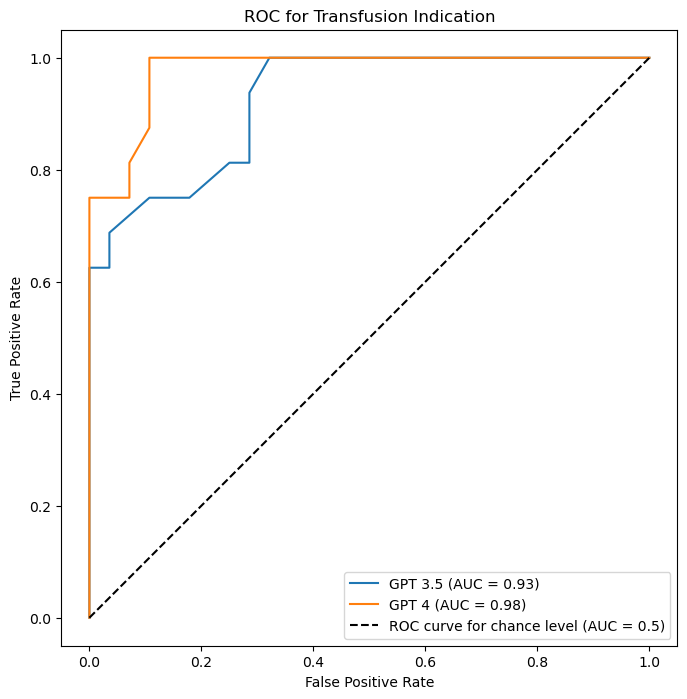

In [27]:
fig, ax = plt.subplots(figsize=(8,8))

temp_df = df[['ID', 'transfusion', 'GPT3_5']]
name = 'GPT 3.5'
RocCurveDisplay.from_predictions(
    y_true=temp_df.transfusion,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)
print(f'Summary statistics for {name} assuming a probability cutoff of >0.5:')
get_metrics(temp_df.transfusion > 0.5, temp_df.iloc[:,-1] > 0.5)

temp_df = df[['ID', 'transfusion', 'GPT_4']]
name = 'GPT 4'
RocCurveDisplay.from_predictions(
    y_true=temp_df.transfusion,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)
print(f'Summary statistics for {name} assuming a probability cutoff of >0.5:')
get_metrics(temp_df.transfusion > 0.5, temp_df.iloc[:,-1] > 0.5)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Transfusion Indication")
plt.legend()
plt.show()

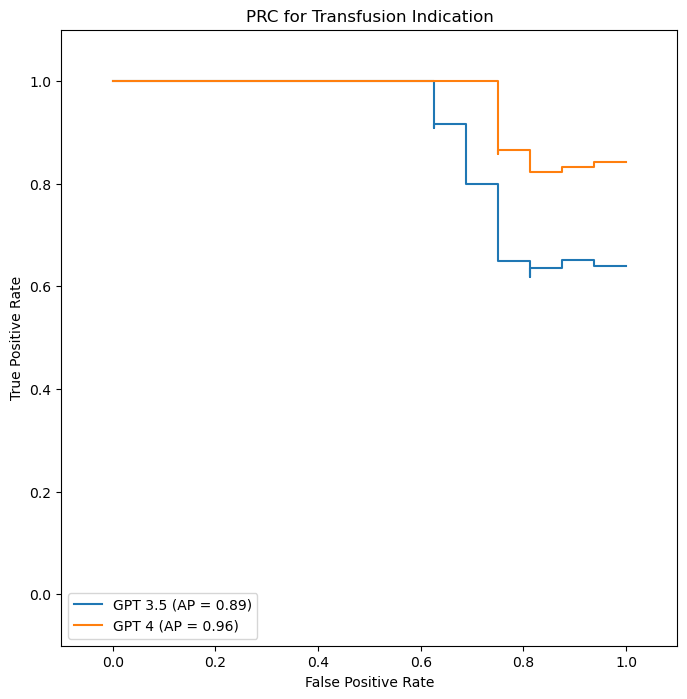

In [26]:
fig, ax = plt.subplots(figsize=(8,8))

temp_df = df[['ID', 'transfusion', 'GPT3_5']]
name = 'GPT 3.5'
PrecisionRecallDisplay.from_predictions(
    y_true=temp_df.transfusion,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)

temp_df = df[['ID', 'transfusion', 'GPT_4']]
name = 'GPT 4'
PrecisionRecallDisplay.from_predictions(
    y_true=temp_df.transfusion,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("PRC for Transfusion Indication")
plt.legend()
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.show()